In [1]:
import sys
sys.path.append('../')
from utils.utils import *

import numpy as np
from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
from scipy import stats

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.proj3d import proj_transform
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

from tensorflow.python.client import device_lib

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16, ResNet50

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs, reduce_variance
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp
import scienceplots


plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '300'})



c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\AN46710\Anaconda3\envs\masters\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
model = ResNet50(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [3]:
filters = get_filter(model, -1)
filters = filters #/ np.sqrt(reduce_variance(filters, axis=None))
theta = getSobelTF(filters)
print(filters.shape)
s, a = getSymAntiSymTF(filters)
a_mag = reduce_euclidean_norm(a, axis=[0,1])
s_mag = reduce_euclidean_norm(s, axis=[0,1])

mag = reduce_euclidean_norm(filters, axis=[0,1])


(3, 3, 512, 512)
(512, 3, 3, 512) (512, 3, 3, 512) (512, 3, 3, 512)


2


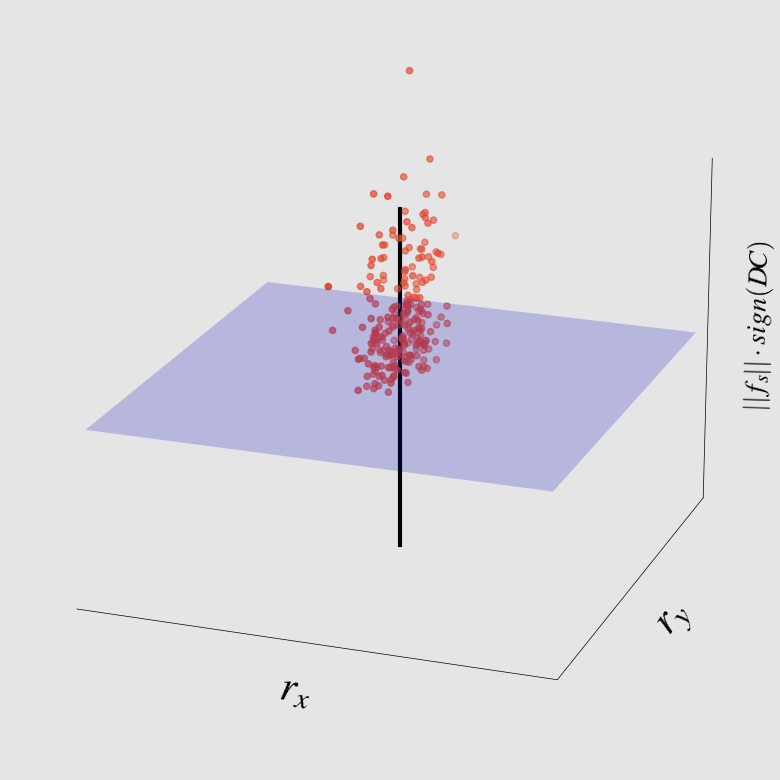

In [73]:
F = 251
x =(a_mag[:,F]*np.cos((theta[:,F]))).numpy()
y =( a_mag[:,F]*np.sin((theta[:,F]))).numpy()
z =(s_mag[:,F]*np.sign(np.mean(s, axis=(0,1)))[:,F]).numpy()


plt.rcParams.update({'figure.dpi': '100'})


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        return np.min(zs)

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

# Create a new figure and a 3D axis
fig = plt.figure(figsize=(10, 10))
ax =  fig.add_subplot(111, projection='3d')
#ax = Axes3D(fig, computed_zorder=True)
# Remove the panes (walls)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# Remove the pane lines
ax.xaxis.pane.set_edgecolor('none')
ax.yaxis.pane.set_edgecolor('none')
ax.zaxis.pane.set_edgecolor('none')

# Remove grid lines
ax.grid(False)

# Remove default tick marks and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

# Create the axes lines
axis_length = 10
line_x  = np.zeros(100)
line_y  = np.zeros(100)

ax.plot(line_x, line_y, np.linspace(-1, 1, 100, endpoint=True), lw='3', color='k')
#ax.plot([0, 0], [0, 0], [-1, 1], 'k-', lw=2)  # z-axis

# Set labels for the axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

arrow_prop_dict = dict(mutation_scale=20, arrowstyle='<|-|>', shrinkA=0, shrinkB=0)



# Color the x,y plane
xx, yy = np.meshgrid(range(-1, 2), range(-1, 2))
# Add text to the x,y plane
#ax.text(0, 0, 0, "X-Y Plane", fontsize=14, ha='center', va='center', 
#        zdir='x', zorder=20)# Example: Plot some 3D points
#points = np.array([x[z<0],y[z<0],z[z<0]]).T*15
#ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='#E24A33', s=20)
ax.plot_surface(xx, yy, np.zeros_like(xx), alpha=0.2, color='blue') 

points = np.array([x[z>0],y[z>0],z[z>0]]).T*15
ax.scatter(points[:, 0], points[:, 1], points[:, 2], color='#E24A33', s=20)
lines = ax.lines
for l in lines:
    print(l.get_zorder())

plt.axis('on')
# Show the plot
ax.set_zlabel('$||f_s||\cdot sign(DC)$', fontsize=20, rotation = 0)
ax.set_xlabel('$r_x$', fontsize=30, rotation = 0)
ax.set_ylabel('$r_y$', fontsize=30, rotation = 0)

fig.set_facecolor('#E5E5E5')
ax.set_facecolor('#E5E5E5') 

ax.view_init(elev=20, azim=-70)

plt.show()

In [77]:
lines[0].get_zorder()

2

In [5]:
fig.savefig('resnet_251_last_3d.pdf', dpi=600)
plt.show()